<a href="https://colab.research.google.com/github/TejasVijaya74/Project-Infy-Chimera/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Setup and Installations**

In [ ]:
# Install required libraries
!pip install pandas requests prophet matplotlib
!pip install transformers torch sentencepiece
!pip install newsapi-python

**Step 2: Imports and Configuration**

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import userdata
from newsapi import NewsApiClient
from transformers import pipeline
import torch

# --- CONFIGURATION ---
CSV_FILE = "combined_news_sentiment.csv"

# Secrets (Add your keys to Colab Secrets)
SLACK_WEBHOOK = userdata.get('SLACK_WEBHOOK_URL')
NEWS_API_KEY = userdata.get('NEWS_API_KEY')

# Alerting thresholds
POSITIVE_THRESHOLD = 5.0
NEGATIVE_THRESHOLD = -5.0

**Step 3: Data Collection & Sentiment Analysis**

In [ ]:
# Initialize News API client
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

# Initialize a sentiment analysis pipeline
# Using a highly-rated model from Hugging Face for accuracy
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

def fetch_and_analyze_news(query="AI innovation", days=30):
    """Fetches news, analyzes sentiment with scores and labels, and saves to a CSV."""
    print(f"Fetching news for query: '{query}'...")
    all_articles = newsapi.get_everything(
        q=query,
        language='en',
        sort_by='relevancy',
        page_size=100
    )

    if not all_articles['articles']:
        print("No articles found.")
        return pd.DataFrame()

    articles_data = []
    print(f"Analyzing sentiment for {len(all_articles['articles'])} fetched articles...")
    for article in all_articles['articles']:
        title = article['title']
        description = article['description']
        published_at = article['publishedAt']

        if description:
            # Analyze the sentiment of the article description
            result = sentiment_analyzer(description[:512])[0]  # Truncate for model input limit

            # Map the model's output label to our custom labels and scores
            label = result['label'].lower() # The model uses 'positive', 'negative', 'neutral'
            score = 0

            if label == 'positive':
                score = result['score'] * 10
            elif label == 'negative':
                score = -result['score'] * 10

            # Append all data to our list
            articles_data.append({
                "publishedAt": published_at,
                "title": title,
                "sentiment_score": score,
                "sentiment_label": label
            })

    df = pd.DataFrame(articles_data)
    df.to_csv(CSV_FILE, index=False)
    print(f"Saved {len(df)} articles with sentiment scores and labels to {CSV_FILE}")
    return df

# --- Execute Data Collection ---
# Run this function to get the latest data.
news_df = fetch_and_analyze_news(query="AI")
print("\n--- Sample of Fetched News Data ---")
print(news_df.head())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Fetching news for query: 'AI'...
Analyzing sentiment for 100 fetched articles...
Saved 100 articles with sentiment scores and labels to combined_news_sentiment.csv

--- Sample of Fetched News Data ---
            publishedAt                                              title  \
0  2025-08-25T14:07:07Z                    AI doesn’t belong in journaling   
1  2025-08-27T12:36:43Z     The Era of AI-Generated Ransomware Has Arrived   
2  2025-08-26T07:00:00Z         AI Is Eliminating Jobs for Younger Workers   
3  2025-09-10T15:00:00Z                  Melania Trump’s AI Era Is Upon Us   
4  2025-09-03T17:54:27Z  Scale AI still exists and it’s suing an ex-emp...   

   sentiment_score sentiment_label  
0         8.645157        positive  
1         0.000000         neutral  
2         0.000000         neutral  
3         8.236939        positive  
4        -7.593673        negative  


**Step 4: Trend Forecasting with Prophet**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ud7nanj/miioc4vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ud7nanj/60jl4lmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20115', 'data', 'file=/tmp/tmp3ud7nanj/miioc4vl.json', 'init=/tmp/tmp3ud7nanj/60jl4lmx.json', 'output', 'file=/tmp/tmp3ud7nanj/prophet_model_nogrimb/prophet_model-20250922175522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Forecasted Sentiment for the Next 7 Days ---
           ds      yhat  yhat_lower  yhat_upper
30 2025-09-21 -1.730765   -4.118335    0.487401
31 2025-09-22  0.733749   -1.635818    3.331111
32 2025-09-23  0.624799   -1.661671    3.004732
33 2025-09-24  0.564735   -1.919111    2.805837
34 2025-09-25  0.613413   -1.874376    3.153552
35 2025-09-26 -0.694851   -3.150699    1.771200
36 2025-09-27 -1.015072   -3.464147    1.350108

Plotting the forecast...


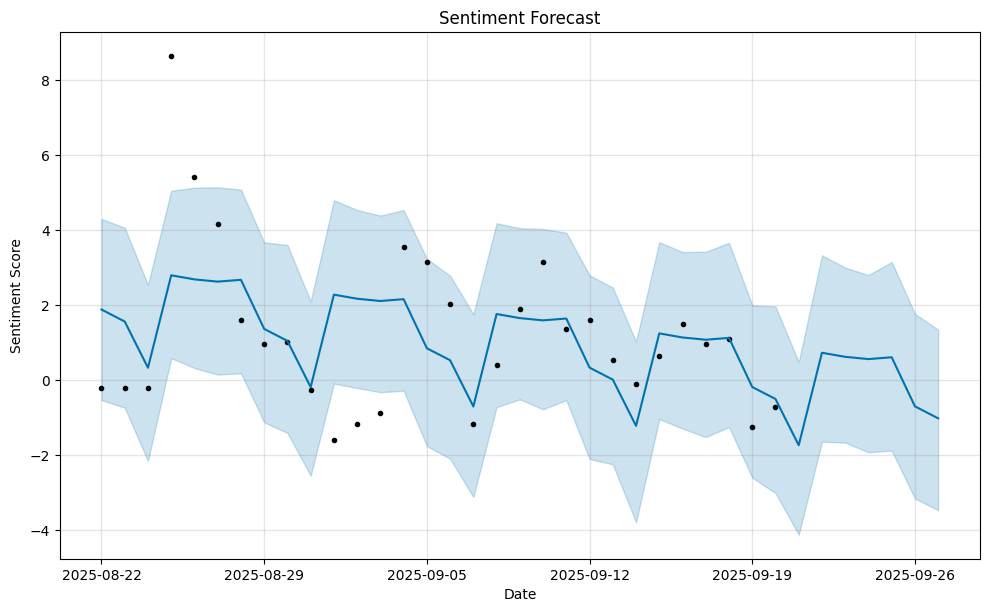

In [ ]:
# --- LOAD CSV ---
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found. Please run the data collection step first.")
    df = pd.DataFrame() # Create an empty df to prevent errors

if not df.empty:
    # --- FORECASTING WITH PROPHET ---
    # Ensure datetime conversion
    if "publishedAt" not in df.columns:
        raise ValueError("CSV must contain a 'publishedAt' column.")

    df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce").dt.tz_localize(None)
    df.dropna(subset=["publishedAt"], inplace=True)

    # Aggregate daily sentiment
    daily_df = df.set_index("publishedAt").resample("D")["sentiment_score"].mean().reset_index()
    daily_df.rename(columns={"publishedAt": "ds", "sentiment_score": "y"}, inplace=True)

    # Optional: Smooth the data
    daily_df["y"] = daily_df["y"].rolling(window=3, min_periods=1).mean()
    daily_df.dropna(inplace=True)

    # Fit Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_df)

    # Forecast 7 days into the future
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    print("\n--- Forecasted Sentiment for the Next 7 Days ---")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

    # --- PLOT RESULTS ---
    print("\nPlotting the forecast...")
    fig = model.plot(forecast, xlabel="Date", ylabel="Sentiment Score")
    plt.title("Sentiment Forecast")
    plt.grid(True)
    plt.show()

**Step 5: Anomaly Detection & Slack Alerts**

In [ ]:
# --- FUNCTION TO SEND SLACK ALERT ---
def send_slack_alert(message: str):
    """Sends a message to the configured Slack webhook."""
    if not SLACK_WEBHOOK:
        print(" Slack Webhook URL not set in Colab secrets.")
        return

    payload = {"text": message}
    try:
        r = requests.post(SLACK_WEBHOOK, json=payload)
        if r.status_code == 200:
            print(f" Slack alert sent: {message}")
        else:
            print(f" Failed to send Slack alert: {r.status_code}, {r.text}")
    except Exception as e:
        print(f" Slack alert error: {e}")

if not df.empty:
    # --- SEND ALERTS BASED ON HISTORICAL SENTIMENT ---
    print("\n--- Checking for Historical Sentiment Alerts ---")
    if "sentiment_score" not in df.columns:
        raise ValueError("CSV must contain a 'sentiment_score' column.")

    for i, row in df.iterrows():
        score = row["sentiment_score"]
        title = row.get("title", "No Title")

        if score > POSITIVE_THRESHOLD:
            send_slack_alert(f"🟢 *Positive Sentiment Alert!* \nScore: `{score:.2f}`\nTitle: `{title}`")
        elif score < NEGATIVE_THRESHOLD:
            send_slack_alert(f"🔴 *Negative Sentiment Alert!* \nScore: `{score:.2f}`\nTitle: `{title}`")

    # --- SEND ALERTS BASED ON FORECASTED TREND ---
    print("\n--- Checking for Forecasted Trend Alerts ---")
    # Check if the forecast predicts a significant positive trend in the next 3 days
    future_positive_peak = forecast.tail(3)['yhat'].max()
    if future_positive_peak > POSITIVE_THRESHOLD:
        send_slack_alert(f" *Positive Trend Forecast!* \nSentiment is predicted to reach `{future_positive_peak:.2f}` in the next 3 days.")

    # Check if the forecast predicts a significant negative trend in the next 3 days
    future_negative_dip = forecast.tail(3)['yhat'].min()
    if future_negative_dip < NEGATIVE_THRESHOLD:
         send_slack_alert(f" *Negative Trend Forecast!* \nSentiment is predicted to drop to `{future_negative_dip:.2f}` in the next 3 days.")
else:
    print("\nSkipping alerts because the dataframe is empty.")


--- Checking for Historical Sentiment Alerts ---
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `8.65`
Title: `AI doesn’t belong in journaling`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `8.24`
Title: `Melania Trump’s AI Era Is Upon Us`
 Slack alert sent: 🔴 *Negative Sentiment Alert!* 
Score: `-7.59`
Title: `Scale AI still exists and it’s suing an ex-employee over corporate espionage`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `6.73`
Title: `Amazon’s Lens Live AI shops for anything you can see`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `9.52`
Title: `The Pixel 10’s AI screamed at us`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `8.70`
Title: `AI super PACs, the hottest investment in tech`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `5.27`
Title: `Microsoft launches its first in-house AI models`
 Slack alert sent: 🟢 *Positive Sentiment Alert!* 
Score: `5.40`
Title: `Microsoft’s Copilot AI is now inside Samsun